In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D # For custom legend (though not used in this cell)

# --- Configuration ---
OUTPUT_DIR = "../result_new"  # Or your actual path
# TARGET_ACCURACY_COC = 0.8 # Not used in Gini/Selection plots, but good to have if other plots use it

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy() # Return a copy even if empty

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique_vals_str = list(map(str, processed_df[col].unique())) # For robust printing
                if verbose: print(f"Column '{col}' before mapping. Unique values (as str): {original_unique_vals_str}")
                # Handle NaN mapping first if present in keys
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else: # No specific NaN mapping, just replace
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. New unique values: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns: # Check if column exists BEFORE trying to process
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()
                if verbose and coerced_nan_count > original_nan_count:
                    print(f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric (were {original_nan_count}).")
                
                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose: print(f"Warning: Column '{col}' (listed in FLOAT_PRECISIONS) not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0.0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique(): # Check if 'No Attack' exists after mapping
            # Ensure ADV_RATE is numeric before this assignment
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')
            
            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose: print("'No Attack' not found in ATTACK_METHOD after mapping; ADV_RATE for 'No Attack' not set to 0.")
    
    return processed_df

# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1,
    'discovery_quality': 1,
    'FINAL_MAIN_ACC': 4,
    'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_BENIGN_PAYMENT_GINI': 3, # Assuming this is AVG_BENIGN_PAYMENT_GINI from your CSV
    'AVG_ADVERSARY_SELECTION_RATE': 3, # This is the proportion of *selected* clients that are adversaries
    'AVG_BENIGN_SELLER_SELECTION_RATE': 3, # This might be rate among available benign, or proportion of selected
    'AVG_COST_PER_ROUND': 2, # Overall average cost per round
    'COST_OF_CONVERGENCE': 0, # Assuming integer rounds/costs
    'TOTAL_COST': 0,        # Assuming integer rounds/costs
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4': 3,
    # Add derived columns here if you want them rounded by the helper,
    # otherwise, round them after derivation.
    'AVG_COST_PER_ROUND_BENIGN': 2,
    'AVG_COST_PER_ROUND_MALICIOUS': 2
}

CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {
        'single': 'Backdoor', 
        np.nan: 'No Attack',  # Handles empty cells in CSV read as pandas NaN
        'None': 'No Attack',   # Handles cells with string 'None'
        'no_attack': 'No Attack' # Handles cells with string 'no_attack'
    },
    'IS_SYBIL': {
        # Assuming your CSV has string 'False' and string 'mimic'
        # If it's boolean True/False, you'd map them:
        # True: 'mimic', 
        # False: 'False' # Keep 'False' as string 'False' for consistency
    }
}

# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame() # Initialize as empty

try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(
        summary_df_avg_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS,
        verbose=True # Enable verbose output for debugging
    )
    
    # --- DERIVE COST COMPOSITION COLUMNS (Benign vs. Malicious Cost per Round) ---
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'
    
    # Check if derivation is sensible (i.e., source columns exist)
    if 'AVG_COST_PER_ROUND' in summary_df_avg.columns and \
       'AVG_ADVERSARY_SELECTION_RATE' in summary_df_avg.columns:
        
        print("Deriving cost composition (benign/malicious) from AVG_COST_PER_ROUND and AVG_ADVERSARY_SELECTION_RATE.")
        
        # Ensure source columns are numeric (they should be after preprocess_experiment_data if listed in FLOAT_PRECISIONS)
        # If not listed, convert them here explicitly before use.
        for col_to_check in ['AVG_COST_PER_ROUND', 'AVG_ADVERSARY_SELECTION_RATE']:
            if col_to_check not in FLOAT_PRECISIONS: # If not already processed by helper
                 if col_to_check in summary_df_avg.columns:
                    summary_df_avg[col_to_check] = pd.to_numeric(summary_df_avg[col_to_check], errors='coerce')
                    print(f"  Ensured column '{col_to_check}' is numeric for derivation.")
                 else:
                    print(f"  Warning: Source column '{col_to_check}' for derivation not found.")
                    # Create empty columns to prevent later key errors if derivation fails
                    summary_df_avg[cost_mal_col] = np.nan
                    summary_df_avg[cost_benign_col] = np.nan


        # For "No Attack" runs, AVG_ADVERSARY_SELECTION_RATE should be 0 for this calculation.
        # The preprocess_experiment_data sets ADV_RATE to 0.
        # Your data generation script should ensure AVG_ADVERSARY_SELECTION_RATE is 0 for No Attack runs.
        # If it might be NaN for No Attack runs, fill it with 0 before calculation.
        adv_sel_rate_for_calc = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].copy()
        # If ATTACK_METHOD is 'No Attack', this rate is definitionally 0.
        # Also, if it's NaN for an attack run (shouldn't happen if data is good), treat as 0 for safety here.
        adv_sel_rate_for_calc[summary_df_avg['ATTACK_METHOD'] == 'No Attack'] = 0.0
        adv_sel_rate_for_calc.fillna(0.0, inplace=True) # Fill any other NaNs with 0 to avoid NaN propagation

        # Calculate derived costs
        summary_df_avg[cost_mal_col] = summary_df_avg['AVG_COST_PER_ROUND'] * adv_sel_rate_for_calc
        summary_df_avg[cost_benign_col] = summary_df_avg['AVG_COST_PER_ROUND'] * (1 - adv_sel_rate_for_calc)
        
        # Round the newly derived columns if they weren't already in FLOAT_PRECISIONS
        # or if derivation might have introduced new float precision issues.
        if cost_mal_col in summary_df_avg.columns:
            summary_df_avg[cost_mal_col] = summary_df_avg[cost_mal_col].round(FLOAT_PRECISIONS.get(cost_mal_col, 2))
        if cost_benign_col in summary_df_avg.columns:
            summary_df_avg[cost_benign_col] = summary_df_avg[cost_benign_col].round(FLOAT_PRECISIONS.get(cost_benign_col, 2))
        print("Derived and processed cost composition columns.")
        
    else:
        print("Warning: Cannot derive cost composition. Missing 'AVG_COST_PER_ROUND' or 'AVG_ADVERSARY_SELECTION_RATE'.")
        # Ensure columns exist as NaN if derivation fails, for consistency in later plotting cells
        if cost_mal_col not in summary_df_avg.columns: summary_df_avg[cost_mal_col] = np.nan
        if cost_benign_col not in summary_df_avg.columns: summary_df_avg[cost_benign_col] = np.nan


    print(f"Processed summary_df_avg shape: {summary_df_avg.shape}")
    if not summary_df_avg.empty:
        print("\nFirst 5 rows of processed summary_df_avg (after potential derivation):")
        display(summary_df_avg.head())
        print("\nInfo of processed summary_df_avg:")
        summary_df_avg.info()

except FileNotFoundError:
    print(f"CRITICAL ERROR: summary_avg.csv not found in {OUTPUT_DIR}. Cannot proceed with plotting.")
    summary_df_avg = pd.DataFrame() # Ensure it's an empty DF if load fails
except Exception as e:
    print(f"CRITICAL ERROR: An error occurred during summary_df_avg loading or preprocessing: {e}")
    summary_df_avg = pd.DataFrame()

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
try:
    all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")
    print("\nall_rounds.csv loaded successfully.")
    all_rounds_df = preprocess_experiment_data(
        all_rounds_df_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS
    )
    print(f"Processed all_rounds_df shape: {all_rounds_df.shape}")
    if not all_rounds_df.empty: display(all_rounds_df.head())
except FileNotFoundError:
    print(f"Error: all_rounds.csv not found in {OUTPUT_DIR}. Please check the path.")
    all_rounds_df = pd.DataFrame()

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# --- Verification ---
if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification (Post-Preprocessing & Derivation) ---")
    check_cols = [
        'AGGREGATION_METHOD', 'ATTACK_METHOD', 'IS_SYBIL', 'ADV_RATE',
        'BENIGN_PAYMENT_GINI_COEFFICIENT', # This is your AVG_BENIGN_PAYMENT_GINI
        'AVG_BENIGN_SELLER_SELECTION_RATE', 
        'AVG_ADVERSARY_SELECTION_RATE',
        'AVG_COST_PER_ROUND_BENIGN', # New derived/processed
        'AVG_COST_PER_ROUND_MALICIOUS', # New derived/processed
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2',
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4'
    ]
    for col in check_cols:
        if col in summary_df_avg.columns:
            unique_vals = summary_df_avg[col].unique()
            try:
                if pd.api.types.is_numeric_dtype(summary_df_avg[col].dtype) and not summary_df_avg[col].empty:
                    valid_numeric_vals = summary_df_avg[col].dropna().unique()
                    unique_vals = sorted(list(valid_numeric_vals)) if len(valid_numeric_vals) > 0 else []
                elif not summary_df_avg[col].empty:
                    # Attempt to sort strings, handle mixed types by converting all to string for sorting
                    unique_vals = sorted(list(map(str, unique_vals)))
            except TypeError:
                 print(f"    (Could not sort unique values for {col} due to mixed types or NaNs)")
                 pass 
            print(f"Unique values in '{col}': {unique_vals}")
            print(f"  NaNs in '{col}': {summary_df_avg[col].isna().sum()}")
        else:
            print(f"VERIFICATION WARNING: Column '{col}' NOT FOUND in processed summary_df_avg.")
else:
    print("\nsummary_df_avg is empty. Verification skipped. Subsequent plots will likely fail.")

--- Preprocessing summary_avg.csv ---
Column 'ATTACK_METHOD' before mapping. Unique values (as str): ['nan', 'single']
Column 'ATTACK_METHOD' mapped. New unique values: ['No Attack' 'Backdoor']
Column 'IS_SYBIL' before mapping. Unique values (as str): ['False', 'default']
Column 'IS_SYBIL' mapped. New unique values: ['False' 'default']
Processing float column: ADV_RATE with precision 1
  Column 'ADV_RATE' rounded. NaNs after rounding: 0
Processing float column: discovery_quality with precision 1
  Column 'discovery_quality' rounded. NaNs after rounding: 0
Processing float column: FINAL_MAIN_ACC with precision 4
  Column 'FINAL_MAIN_ACC' rounded. NaNs after rounding: 0
Processing float column: FINAL_ASR with precision 4
  Column 'FINAL_ASR' rounded. NaNs after rounding: 38
Processing float column: PAYMENT_GINI_COEFFICIENT with precision 3
  Column 'PAYMENT_GINI_COEFFICIENT' rounded. NaNs after rounding: 0
Processing float column: AVG_BENIGN_PAYMENT_GINI with precision 3
  Column 'AVG_BE

,DATASET,PAYMENT_GINI_COEFFICIENT,FINAL_TRIGGERED_ACC,ROUNDS_TO_70ACC,benign_rounds,FINAL_MAIN_ACC,COST_TO_75ACC,COST_TO_90ACC,MAX_ASR,TRIGGER_RATE,...,COC_TARGET_REACHED_ROUND,TARGET_ACC_FOR_COC,ROUNDS_TO_75ACC,NO_ATTACK_DESIG_MAL_SEL_RATE_0.1,ROUNDS_TO_90ACC,DATA_SPLIT_MODE,ROUNDS_TO_80ACC,exp_path,AVG_COST_PER_ROUND_MALICIOUS,AVG_COST_PER_ROUND_BENIGN
0,CIFAR,0.0,NaN,NaN,5.0,0.3066,NaN,NaN,0.0,0.0,...,-1.0,0.8,NaN,0.1,NaN,discovery,NaN,./experiment_results_revised/privacy/gradient_...,0.00,10.00
1,FMNIST,0.0,NaN,6.0,5.0,0.9004,105.0,1905.0,0.0,0.0,...,17.0,0.8,10.5,0.1,190.5,discovery,18.0,./experiment_results_revised/privacy/gradient_...,0.00,10.00
2,CIFAR,0.0,NaN,NaN,5.0,0.2966,NaN,NaN,0.0,0.2,...,-1.0,0.8,NaN,NaN,NaN,discovery,NaN,./experiment_results_revised/label_flip_attack...,3.00,7.00
3,FMNIST,0.0,NaN,5.5,5.0,0.8396,62.5,NaN,0.0,0.2,...,18.0,0.8,10.0,NaN,NaN,discovery,19.0,./experiment_results_revised/label_flip_attack...,0.01,1.49
4,CIFAR,0.0,NaN,NaN,5.0,0.3318,NaN,NaN,0.0,0.2,...,-1.0,0.8,NaN,NaN,NaN,discovery,NaN,./experiment_results_revised/label_flip_attack...,1.73,4.91



Info of processed summary_df_avg:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 49 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   DATASET                                 44 non-null     object 
 1   PAYMENT_GINI_COEFFICIENT                44 non-null     float64
 2   FINAL_TRIGGERED_ACC                     0 non-null      float64
 3   ROUNDS_TO_70ACC                         20 non-null     float64
 4   benign_rounds                           44 non-null     float64
 5   FINAL_MAIN_ACC                          44 non-null     float64
 6   COST_TO_75ACC                           20 non-null     float64
 7   COST_TO_90ACC                           5 non-null      float64
 8   MAX_ASR                                 44 non-null     float64
 9   TRIGGER_RATE                            44 non-null     float64
 10  AVG_ADVERSARY_SELECTION_RATE 

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_285484\3153843679.py:188: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")


,run,round,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,CHANGE_BASE,benign_rounds,attack_objective,AGGREGATION_METHOD,...,NO_ATTACK_DESIG_MAL_SEL_RATE_0.2_ROUND,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3_ROUND,NO_ATTACK_DESIG_MAL_SEL_RATE_0.4_ROUND,main_acc,main_loss,clean_acc,triggered_acc,asr,avg_selected_data_distribution_similarity,avg_unselected_data_distribution_similarity
0,1,0,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.2253,2.224315,NaN,NaN,NaN,0,0.966503
1,1,1,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.2666,2.209247,NaN,NaN,NaN,0,0.966503
2,1,2,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.3475,2.205690,NaN,NaN,NaN,0,0.966503
3,1,3,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.3547,2.205690,NaN,NaN,NaN,0,0.966503
4,1,4,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.3022,2.202605,NaN,NaN,NaN,0,0.966503



--- Processed Summary Data Verification (Post-Preprocessing & Derivation) ---
Unique values in 'AGGREGATION_METHOD': ['fedavg', 'fltrust', 'martfl', 'skymask']
  NaNs in 'AGGREGATION_METHOD': 0
Unique values in 'ATTACK_METHOD': ['Backdoor', 'No Attack']
  NaNs in 'ATTACK_METHOD': 0
Unique values in 'IS_SYBIL': ['False', 'default']
  NaNs in 'IS_SYBIL': 0
Unique values in 'ADV_RATE': [np.float64(0.0), np.float64(0.3)]
  NaNs in 'ADV_RATE': 0
VERIFICATION WARNING: Column 'BENIGN_PAYMENT_GINI_COEFFICIENT' NOT FOUND in processed summary_df_avg.
Unique values in 'AVG_BENIGN_SELLER_SELECTION_RATE': [np.float64(0.104), np.float64(0.11), np.float64(0.146), np.float64(0.21), np.float64(0.228), np.float64(0.25), np.float64(0.255), np.float64(0.303), np.float64(0.381), np.float64(0.46), np.float64(0.479), np.float64(0.565), np.float64(0.639), np.float64(0.643), np.float64(0.65), np.float64(0.692), np.float64(0.698), np.float64(0.998), np.float64(0.999), np.float64(1.0)]
  NaNs in 'AVG_BENIGN_SEL

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ------------ 1.  paths -----------------\
OUTPUT_DIR = "../result_new"  # Or your actual path

CSV_PATH = f"./{OUTPUT_DIR}/summary_avg.csv"   # <-- UPDATE if your csv is elsewhere
OUT_DIR  = f"./{OUTPUT_DIR}/figures"
os.makedirs(OUT_DIR, exist_ok=True)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# --- Configuration ---
# Ensure these match your DataFrame's unique values
# DATASETS_TO_ANALYZE = sorted(summary_df_avg['DATASET'].unique())
# AGGREGATION_METHODS_TO_ANALYZE = sorted(summary_df_avg['AGGREGATION_METHOD'].unique())
LABEL_FLIPPING_ATTACK_NAME = 'label_flip' # Or whatever it's named in your ATTACK_METHOD column
NO_ATTACK_NAME = 'None'

# Fixed parameters for comparison (ADJUST AS NEEDED)
# These should be common settings under which you compare NoAttack vs. LabelFlipping
FIXED_DISCOVERY_QUALITY_COMPARE = 1.0
FIXED_BUYER_MODE_COMPARE = 'random'
# FIXED_TRIGGER_RATE_FOR_LF = 0.1 # The trigger rate used for the LabelFlipping attacks being analyzed
                               # For 'NoAttack', trigger rate will be 0.

# --- Output Paths ---
BASE_SAVE_DIR_LF_ANALYSIS = "./results/paper_figures/label_flipping_robustness/"
os.makedirs(BASE_SAVE_DIR_LF_ANALYSIS, exist_ok=True)

# --- Load Data ---
# This script assumes summary_df_avg is already loaded and preprocessed
# and contains 'CONFIG_ADV_RATE' (the adv_rate of the underlying population)
# and for NoAttack runs, AVG_ADVERSARY_SELECTION_RATE reflects the selection of designated malicious clients.

if 'summary_df_avg' not in locals() or summary_df_avg.empty:
    print("CRITICAL ERROR: 'summary_df_avg' DataFrame not found or is empty.")
    print("Please ensure it's loaded from your processing script and contains 'CONFIG_ADV_RATE'.")
    # Dummy data for layout testing
    datasets_dummy = ['FMNIST']
    aggregators_dummy = ['MartFL', 'FedAvg']
    adv_rates_config_dummy = [0.3]
    dummy_data_list_lf = []
    for ds in datasets_dummy:
        for agg in aggregators_dummy:
            for adv_c in adv_rates_config_dummy:
                # No Attack
                dummy_data_list_lf.append({
                    'DATASET': ds, 'AGGREGATION_METHOD': agg, 'ATTACK_METHOD': NO_ATTACK_NAME, 
                    'ADV_RATE': 0.0, 'CONFIG_ADV_RATE': adv_c, # ADV_RATE is effective, CONFIG_ADV_RATE is population
                    'TRIGGER_RATE': 0.0, 'discovery_quality': FIXED_DISCOVERY_QUALITY_COMPARE,
                    'buyer_data_mode': FIXED_BUYER_MODE_COMPARE, 'IS_SYBIL': 'False',
                    'FINAL_MAIN_ACC': 0.85 - (0.05 if agg=='FedAvg' else 0) + np.random.normal(0,0.01),
                    'FINAL_ASR': 0.0,
                    'AVG_ADVERSARY_SELECTION_RATE': adv_c * np.random.uniform(0.3, 0.6) # Selection of designated
                })
                # Label Flipping Attack
                dummy_data_list_lf.append({
                    'DATASET': ds, 'AGGREGATION_METHOD': agg, 'ATTACK_METHOD': LABEL_FLIPPING_ATTACK_NAME,
                    'ADV_RATE': adv_c, 'CONFIG_ADV_RATE': adv_c, # ADV_RATE and CONFIG_ADV_RATE are same for active attack
                    'TRIGGER_RATE': 0.1, 'discovery_quality': FIXED_DISCOVERY_QUALITY_COMPARE, # Assuming a fixed trigger rate for LF
                    'buyer_data_mode': FIXED_BUYER_MODE_COMPARE, 'IS_SYBIL': 'False',
                    'FINAL_MAIN_ACC': (0.85 - (0.05 if agg=='FedAvg' else 0)) - adv_c * (0.5 if agg=='FedAvg' else 0.2) + np.random.normal(0,0.02),
                    'FINAL_ASR': adv_c * np.random.uniform(0.2, 0.5), # LF ASR might be lower/measured differently
                    'AVG_ADVERSARY_SELECTION_RATE': adv_c * np.random.uniform(0.4, 0.7)
                })
    summary_df_avg = pd.DataFrame(dummy_data_list_lf)
    summary_df_avg['FINAL_MAIN_ACC'] = summary_df_avg['FINAL_MAIN_ACC'].clip(0,1)
    summary_df_avg['FINAL_ASR'] = summary_df_avg['FINAL_ASR'].clip(0,1)
    summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'] = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].clip(0,1)

else:
    print("'summary_df_avg' DataFrame is available.")
    if 'CONFIG_ADV_RATE' not in summary_df_avg.columns:
        print("ERROR: 'CONFIG_ADV_RATE' column is missing from summary_df_avg. This is needed for pairing NoAttack and Attack runs based on underlying population.")
        # Potentially try to create it if 'ADV_RATE' for NoAttack runs actually stores the population adv_rate
        # For example, if for ATTACK_METHOD=='NoAttack', the ADV_RATE column IS the population adv_rate:
        # summary_df_avg['CONFIG_ADV_RATE'] = summary_df_avg['ADV_RATE']
        # And then ensure the ADV_RATE column for NoAttack is set to 0 for plotting:
        # summary_df_avg.loc[summary_df_avg['ATTACK_METHOD'] == NO_ATTACK_NAME, 'ADV_RATE'] = 0.0
        # This depends heavily on how your data was saved. The ideal is that 'CONFIG_ADV_RATE' was explicitly saved.


DATASETS_TO_ANALYZE = sorted(summary_df_avg['DATASET'].unique())
AGGREGATION_METHODS_TO_ANALYZE = sorted(summary_df_avg['AGGREGATION_METHOD'].unique())

# --- Data Preparation for Pairing ---
# Columns to join/pair on (must be identical for NoAttack and LabelFlipping runs)
# Use CONFIG_ADV_RATE for pairing, as it represents the underlying population for both scenarios.
pairing_cols = ['DATASET', 'AGGREGATION_METHOD', 'CONFIG_ADV_RATE',
                'discovery_quality', 'buyer_data_mode', 'IS_SYBIL'
                # Add any other benign condition parameters that should match
               ]
# Ensure all pairing columns exist
pairing_cols = [col for col in pairing_cols if col in summary_df_avg.columns]
if 'CONFIG_ADV_RATE' not in pairing_cols :
    print("ERROR: 'CONFIG_ADV_RATE' is crucial for pairing and is missing or not included in pairing_cols.")
    # exit()


# Filter for relevant data
df_lf = summary_df_avg[
    (summary_df_avg['ATTACK_METHOD'] == LABEL_FLIPPING_ATTACK_NAME) &
    (summary_df_avg['discovery_quality'] == FIXED_DISCOVERY_QUALITY_COMPARE) & # Example fixed condition
    (summary_df_avg['buyer_data_mode'] == FIXED_BUYER_MODE_COMPARE)      # Example fixed condition
    # (summary_df_avg['TRIGGER_RATE'] == FIXED_TRIGGER_RATE_FOR_LF) # Add if LF runs have a specific trigger rate to focus on
].copy()

df_no_attack = summary_df_avg[
    (summary_df_avg['ATTACK_METHOD'] == NO_ATTACK_NAME) &
    (summary_df_avg['discovery_quality'] == FIXED_DISCOVERY_QUALITY_COMPARE) &
    (summary_df_avg['buyer_data_mode'] == FIXED_BUYER_MODE_COMPARE) &
    (summary_df_avg['TRIGGER_RATE'] == 0.0) # NoAttack runs should have trigger_rate = 0
].copy()


if df_lf.empty:
    print(f"Warning: No data found for Label Flipping attacks with specified fixed conditions.")
if df_no_attack.empty:
    print(f"Warning: No data found for No Attack baselines with specified fixed conditions.")

# Rename columns for clarity before merging
df_lf = df_lf.rename(columns={
    'FINAL_MAIN_ACC': 'ACC_LabelFlipping',
    'AVG_ADVERSARY_SELECTION_RATE': 'SelRate_LabelFlipping',
    'ADV_RATE': 'ADV_RATE_Attack' # Effective adv rate during LF attack
})
df_no_attack = df_no_attack.rename(columns={
    'FINAL_MAIN_ACC': 'ACC_NoAttack',
    'AVG_ADVERSARY_SELECTION_RATE': 'SelRate_Designated_NoAttack', # Selection of those who *would be* adversaries
    'ADV_RATE': 'ADV_RATE_NoAttack_Effective' # Should be 0.0
})

# Select only necessary columns before merge to avoid duplicate column issues if some params differ slightly
cols_to_select_lf = pairing_cols + ['ACC_LabelFlipping', 'SelRate_LabelFlipping', 'ADV_RATE_Attack', 'TRIGGER_RATE']
cols_to_select_no_attack = pairing_cols + ['ACC_NoAttack', 'SelRate_Designated_NoAttack', 'ADV_RATE_NoAttack_Effective']

df_lf_select = df_lf[[col for col in cols_to_select_lf if col in df_lf.columns]].copy()
df_no_attack_select = df_no_attack[[col for col in cols_to_select_no_attack if col in df_no_attack.columns]].copy()


# Merge to get paired data
# Ensure no duplicate pairing_cols rows in df_lf_select or df_no_attack_select before merge
# This can happen if other unlisted params vary. If so, you need to average them first.
# For simplicity here, we assume summary_df_avg is already averaged over seeds.
df_paired = pd.merge(df_lf_select, df_no_attack_select, on=pairing_cols, how='inner')

if df_paired.empty:
    print("Warning: No paired data found between Label Flipping and No Attack runs after merge. Check pairing_cols and fixed conditions.")
else:
    print(f"Successfully paired {len(df_paired)} experiment settings.")
    df_paired['ACC_Drop'] = df_paired['ACC_NoAttack'] - df_paired['ACC_LabelFlipping']
    df_paired['SelRate_Change'] = df_paired['SelRate_LabelFlipping'] - df_paired['SelRate_Designated_NoAttack']


# --- PLOT TYPE 1: Paired Bar Charts ---
# Example: Accuracy Drop for a fixed CONFIG_ADV_RATE, across AGGREGATION_METHODs
FIXED_CONFIG_ADV_RATE_FOR_BAR = 0.3 # Example

if not df_paired.empty:
    df_bar_data_prep = df_paired[df_paired['CONFIG_ADV_RATE'] == FIXED_CONFIG_ADV_RATE_FOR_BAR].copy()
    
    if not df_bar_data_prep.empty:
        # Melt for easier plotting with seaborn barplot
        df_bar_acc = pd.melt(df_bar_data_prep,
                             id_vars=['DATASET', 'AGGREGATION_METHOD'],
                             value_vars=['ACC_NoAttack', 'ACC_LabelFlipping'],
                             var_name='Condition', value_name='FINAL_MAIN_ACC')
        df_bar_acc['Condition'] = df_bar_acc['Condition'].replace({'ACC_NoAttack': 'No Attack', 'ACC_LabelFlipping': 'Label Flipping'})

        df_bar_sel = pd.melt(df_bar_data_prep,
                             id_vars=['DATASET', 'AGGREGATION_METHOD'],
                             value_vars=['SelRate_Designated_NoAttack', 'SelRate_LabelFlipping'],
                             var_name='Condition', value_name='AVG_ADVERSARY_SELECTION_RATE')
        df_bar_sel['Condition'] = df_bar_sel['Condition'].replace({'SelRate_Designated_NoAttack': 'Designated (No Attack)',
                                                                 'SelRate_LabelFlipping': 'Actual (Label Flipping)'})

        # Plotting Accuracy Comparison
        plt.figure(figsize=(8, 5))
        sns.barplot(x='AGGREGATION_METHOD', y='FINAL_MAIN_ACC', hue='Condition', data=df_bar_acc, palette={'No Attack':'skyblue', 'Label Flipping':'salmon'})
        plt.title(f'Accuracy: No Attack vs. Label Flipping\n(Config Adv. Rate={FIXED_CONFIG_ADV_RATE_FOR_BAR}, DQ={FIXED_DISCOVERY_QUALITY_COMPARE}, Buyer={FIXED_BUYER_MODE_COMPARE.capitalize()})', fontsize=12)
        plt.ylabel('Final Main Accuracy')
        plt.xlabel('Aggregation Method')
        plt.xticks(rotation=15, ha='right')
        plt.ylim(0, 1.05)
        plt.legend(title='Scenario')
        plt.grid(axis='y', linestyle=':', linewidth=0.7)
        plt.tight_layout()
        filename_bar_acc = f"{BASE_SAVE_DIR_LF_ANALYSIS}bar_acc_compare_adv{FIXED_CONFIG_ADV_RATE_FOR_BAR}.pdf"
        try: plt.savefig(filename_bar_acc, bbox_inches='tight'); print(f"Saved: {filename_bar_acc}")
        except Exception as e: print(f"Error saving {filename_bar_acc}: {e}")
        plt.show()

        # Plotting Adversary Selection Rate Comparison
        plt.figure(figsize=(8, 5))
        sns.barplot(x='AGGREGATION_METHOD', y='AVG_ADVERSARY_SELECTION_RATE', hue='Condition', data=df_bar_sel, palette={'Designated (No Attack)':'lightgreen', 'Actual (Label Flipping)':'coral'})
        plt.title(f'Adversary Selection: No Attack vs. Label Flipping\n(Config Adv. Rate={FIXED_CONFIG_ADV_RATE_FOR_BAR}, DQ={FIXED_DISCOVERY_QUALITY_COMPARE}, Buyer={FIXED_BUYER_MODE_COMPARE.capitalize()})', fontsize=12)
        plt.ylabel('Avg. Adversary Group Selection Rate')
        plt.xlabel('Aggregation Method')
        plt.xticks(rotation=15, ha='right')
        plt.ylim(0, 1.05)
        plt.legend(title='Adversary Selection')
        plt.grid(axis='y', linestyle=':', linewidth=0.7)
        plt.tight_layout()
        filename_bar_sel = f"{BASE_SAVE_DIR_LF_ANALYSIS}bar_selrate_compare_adv{FIXED_CONFIG_ADV_RATE_FOR_BAR}.pdf"
        try: plt.savefig(filename_bar_sel, bbox_inches='tight'); print(f"Saved: {filename_bar_sel}")
        except Exception as e: print(f"Error saving {filename_bar_sel}: {e}")
        plt.show()
    else:
        print(f"No data for bar charts at CONFIG_ADV_RATE = {FIXED_CONFIG_ADV_RATE_FOR_BAR}")


# --- PLOT TYPE 2: Line Plots vs. CONFIG_ADV_RATE ---
if not df_paired.empty:
    df_line_acc = pd.melt(df_paired,
                          id_vars=['DATASET', 'AGGREGATION_METHOD', 'CONFIG_ADV_RATE'],
                          value_vars=['ACC_NoAttack', 'ACC_LabelFlipping'],
                          var_name='Condition', value_name='FINAL_MAIN_ACC')
    df_line_acc['Condition'] = df_line_acc['Condition'].replace({'ACC_NoAttack': 'No Attack', 'ACC_LabelFlipping': 'Label Flipping'})

    df_line_sel = pd.melt(df_paired,
                          id_vars=['DATASET', 'AGGREGATION_METHOD', 'CONFIG_ADV_RATE'],
                          value_vars=['SelRate_Designated_NoAttack', 'SelRate_LabelFlipping'],
                          var_name='Condition', value_name='AVG_ADVERSARY_SELECTION_RATE')
    df_line_sel['Condition'] = df_line_sel['Condition'].replace({'SelRate_Designated_NoAttack': 'Designated (No Attack)',
                                                               'SelRate_LabelFlipping': 'Actual (Label Flipping)'})
    
    for dataset in DATASETS_TO_ANALYZE:
        df_line_acc_ds = df_line_acc[df_line_acc['DATASET'] == dataset]
        df_line_sel_ds = df_line_sel[df_line_sel['DATASET'] == dataset]

        if not df_line_acc_ds.empty:
            plt.figure(figsize=(8, 5.5))
            sns.lineplot(x='CONFIG_ADV_RATE', y='FINAL_MAIN_ACC', hue='AGGREGATION_METHOD',
                         style='Condition', data=df_line_acc_ds, markers=True, palette='viridis')
            plt.title(f'Accuracy vs. Config. Adversary Rate on {dataset}\n(DQ={FIXED_DISCOVERY_QUALITY_COMPARE}, Buyer={FIXED_BUYER_MODE_COMPARE.capitalize()})', fontsize=12)
            plt.xlabel('Configured Adversary Rate (Population)')
            plt.ylabel('Final Main Accuracy')
            plt.ylim(0, 1.05)
            plt.grid(True, linestyle=':', linewidth=0.7)
            plt.legend(title='Scenario', bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.tight_layout(rect=[0,0,0.85,0.95])
            filename_line_acc = f"{BASE_SAVE_DIR_LF_ANALYSIS}{dataset}_line_acc_vs_config_adv_rate.pdf"
            try: plt.savefig(filename_line_acc, bbox_inches='tight'); print(f"Saved: {filename_line_acc}")
            except Exception as e: print(f"Error saving {filename_line_acc}: {e}")
            plt.show()

        if not df_line_sel_ds.empty:
            plt.figure(figsize=(8, 5.5))
            sns.lineplot(x='CONFIG_ADV_RATE', y='AVG_ADVERSARY_SELECTION_RATE', hue='AGGREGATION_METHOD',
                         style='Condition', data=df_line_sel_ds, markers=True, palette='viridis')
            plt.title(f'Adversary Selection vs. Config. Adversary Rate on {dataset}\n(DQ={FIXED_DISCOVERY_QUALITY_COMPARE}, Buyer={FIXED_BUYER_MODE_COMPARE.capitalize()})', fontsize=12)
            plt.xlabel('Configured Adversary Rate (Population)')
            plt.ylabel('Avg. Adversary Group Selection Rate')
            plt.ylim(0, 1.05)
            plt.grid(True, linestyle=':', linewidth=0.7)
            plt.legend(title='Scenario', bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.tight_layout(rect=[0,0,0.85,0.95])
            filename_line_sel = f"{BASE_SAVE_DIR_LF_ANALYSIS}{dataset}_line_selrate_vs_config_adv_rate.pdf"
            try: plt.savefig(filename_line_sel, bbox_inches='tight'); print(f"Saved: {filename_line_sel}")
            except Exception as e: print(f"Error saving {filename_line_sel}: {e}")
            plt.show()
else:
    print("No paired data available for line plots.")

print("\n--- Label Flipping Robustness Analysis Plot Generation Complete ---")

'summary_df_avg' DataFrame is available.
No paired data available for line plots.

--- Label Flipping Robustness Analysis Plot Generation Complete ---


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# CONFIG – tweak as needed or turn them into CLI args
# ---------------------------------------------------------------------
CSV_PATH              = Path("../result_new/summary_avg.csv")   # your upload
FIXED_POP_ADV_RATE    = 0.3       # pair on this population rate
DISCOVERY_QUALITY     = 0.3
BUYER_MODE            = "unbiased"
SAVE_DIR              = Path("./results/paper_figures/label_flipping_robustness_csv")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------------------------------------

ATTACK_LABELS = {
    "label_flip":  "LabelFlipping",
    "backdoor":    "Backdoor",
    None:          "NoAttack",
    "":            "NoAttack"
}

def load_and_tag(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # Tag rows with an EFFECTIVE_ATTACK column
    df["EFFECTIVE_ATTACK"] = (
        df["attack_objective"]
        .map(lambda x: ATTACK_LABELS.get(str(x).strip().lower(), "UnknownAttack"))
    )

    # Derive No‑Attack rows when adv rate is 0
    df.loc[df["ADV_RATE"].eq(0), "EFFECTIVE_ATTACK"] = "NoAttack"

    # Keep separate columns for clarity
    df = df.rename(columns={"ADV_RATE": "ADV_RATE_effective"})
    df["ADV_RATE_population"] = df["ADV_RATE_effective"].where(
        df["EFFECTIVE_ATTACK"] != "NoAttack", FIXED_POP_ADV_RATE
    )
    return df

def make_barplots(df: pd.DataFrame, dataset: str, attack: str) -> None:
    """
    Produces two bar charts (accuracy & selection rate) for one dataset + attack.
    Saves them as PDF in SAVE_DIR and shows them inline.
    """
    base = df.query(
        "DATASET == @dataset and "
        "discovery_quality == @DISCOVERY_QUALITY and "
        "buyer_data_mode == @BUYER_MODE and "
        "ADV_RATE_population == @FIXED_POP_ADV_RATE"
    )

    df_attack  = base.query("EFFECTIVE_ATTACK == @attack").copy()
    df_no_atk  = base.query("EFFECTIVE_ATTACK == 'NoAttack'").copy()

    if df_attack.empty or df_no_atk.empty:
        print(f"[skip] {dataset}: missing rows for attack={attack}")
        return
    print(df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]])
    print(df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]])

    paired = pd.merge(
        df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]],
        df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]],
        on="AGGREGATION_METHOD",
        suffixes=("_attack", "_baseline")
    )

    # ---------- Accuracy ----------
    acc_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=["FINAL_MAIN_ACC_baseline",
                                       "FINAL_MAIN_ACC_attack"],
                           var_name="Scenario", value_name="Accuracy")
    acc_long["Scenario"] = acc_long["Scenario"].map({
        "FINAL_MAIN_ACC_baseline": "No Attack",
        "FINAL_MAIN_ACC_attack":   attack
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=acc_long,
                x="AGGREGATION_METHOD", y="Accuracy", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Final Main Accuracy")
    plt.title(f"{dataset} – Accuracy\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"acc_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)

    # ---------- Selection rate ----------
    sel_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=[f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}",
                                       "AVG_ADVERSARY_SELECTION_RATE"],
                           var_name="Scenario", value_name="SelRate")
    sel_long["Scenario"] = sel_long["Scenario"].map({
        f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}": "Designated (NoAttack)",
        "AVG_ADVERSARY_SELECTION_RATE": f"Actual ({attack})"
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=sel_long,
                x="AGGREGATION_METHOD", y="SelRate", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Adversary Selection Rate")
    plt.title(f"{dataset} – Selection Rate\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"sel_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)
    plt.show()
    


  AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
2            skymask        0.296567                      0.300000
4            fltrust        0.331800                      0.261026
9             martfl        0.231567                      0.001667
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
0              fedavg        0.306600                          0.300000
10            skymask        0.330000                          0.300000
11             martfl        0.231567                          0.001667
12             martfl        0.231567                          0.001667
15             fedavg        0.326033                          0.300000
17             fedavg        0.326033                          0.300000
19            skymask        0.330000                          0.300000
22            fltrust        0.383533                          0.278203
30            fltrust        0.371600                          0.281248
36          

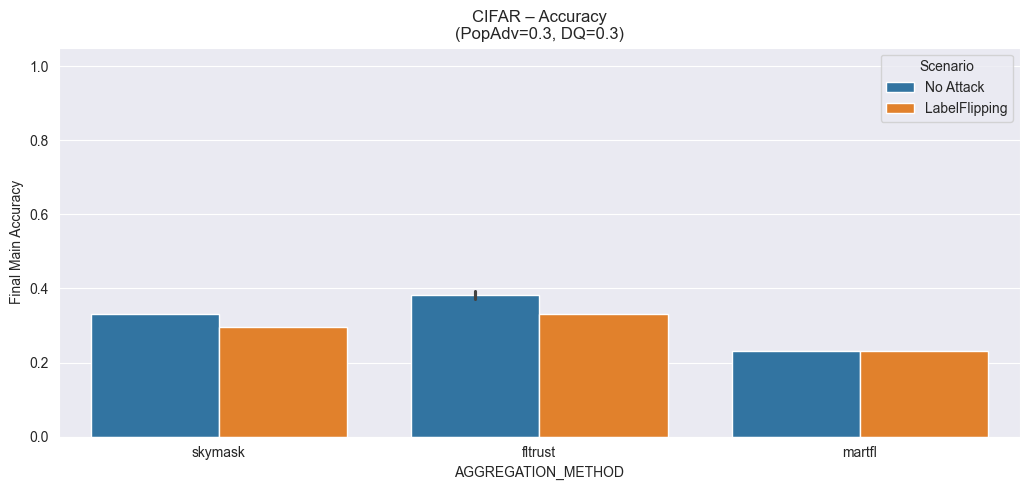

saved results\paper_figures\label_flipping_robustness_csv\acc_CIFAR_LabelFlipping.pdf


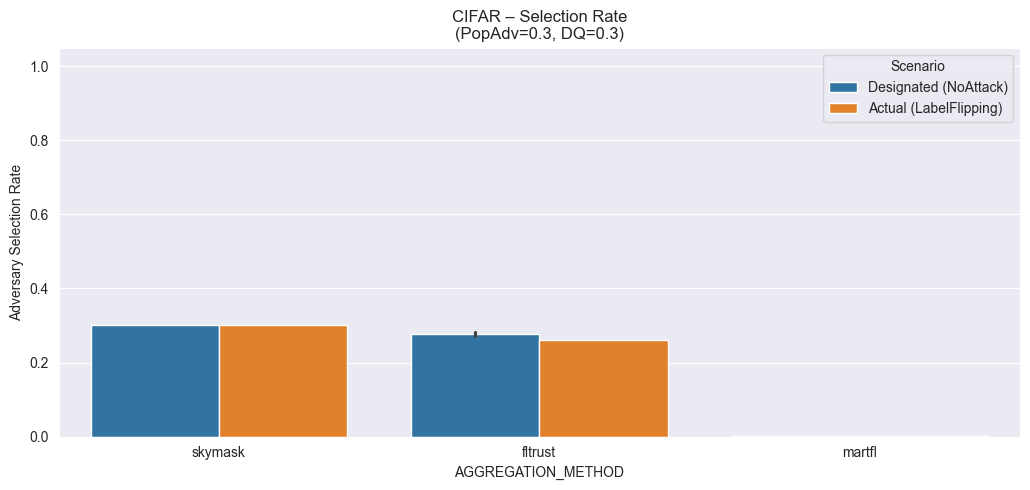

saved results\paper_figures\label_flipping_robustness_csv\sel_CIFAR_LabelFlipping.pdf
  AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
3             martfl        0.839550                      0.004464
5             fedavg        0.894867                      0.300000
7            skymask        0.895400                      0.300000
8            fltrust        0.793500                      0.238894
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
1              fedavg        0.900350                          0.300000
13            skymask        0.899400                          0.300000
14             fedavg        0.899467                          0.300000
16            fltrust        0.795733                          0.300000
18             martfl        0.850333                          0.332782
20             martfl        0.850333                          0.332782
21            skymask        0.899400                          0.300000
23 

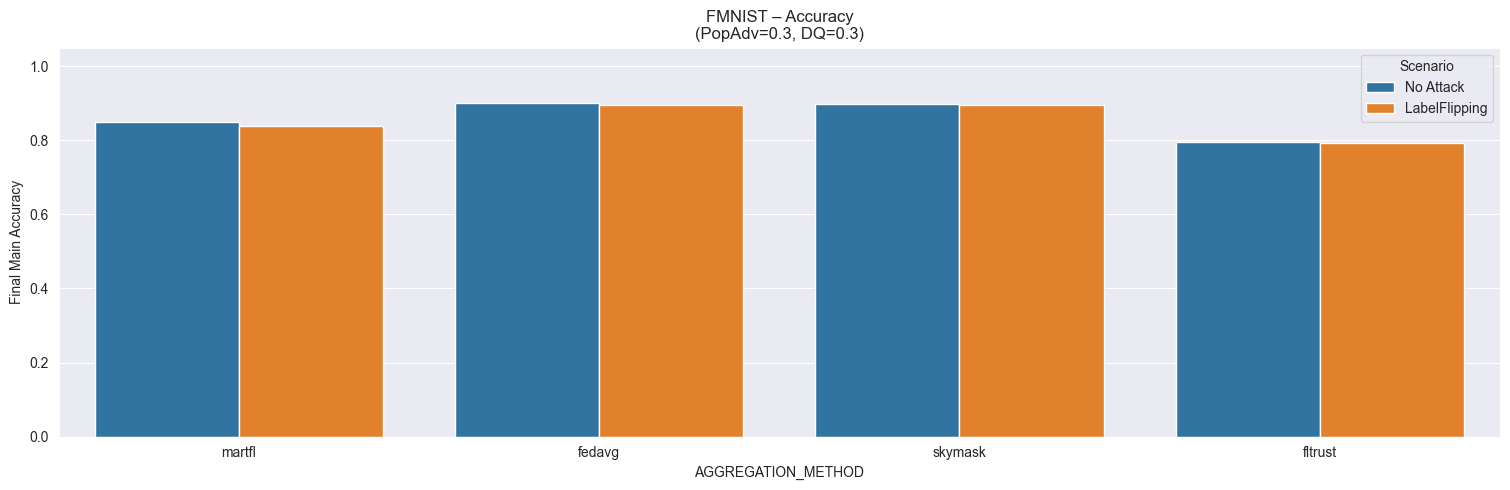

saved results\paper_figures\label_flipping_robustness_csv\acc_FMNIST_LabelFlipping.pdf


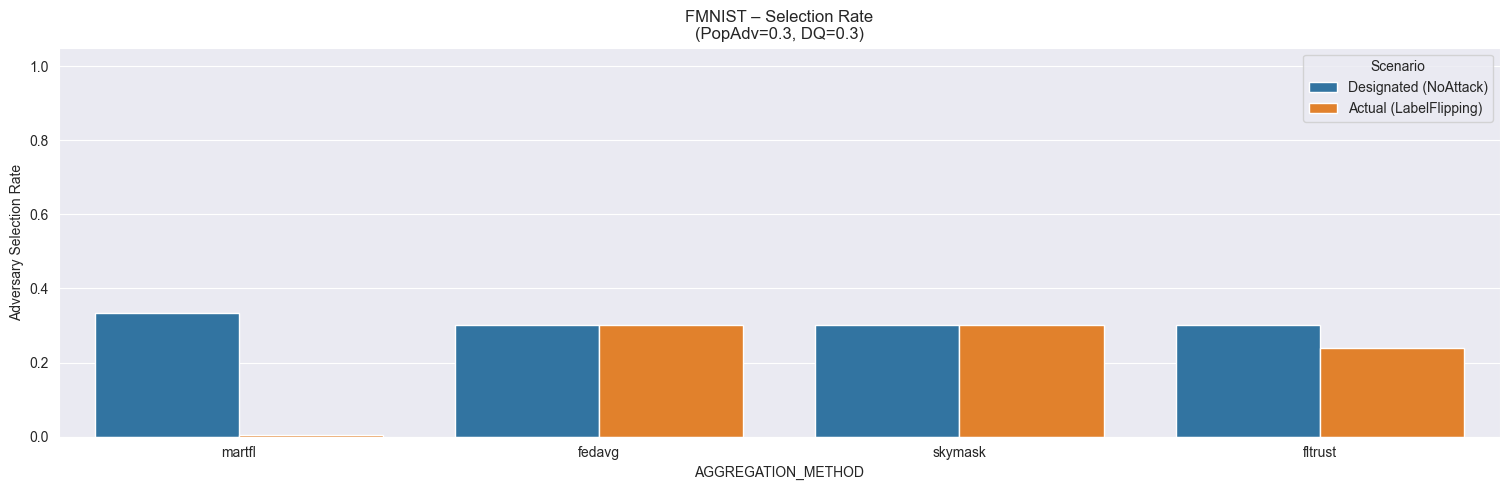

saved results\paper_figures\label_flipping_robustness_csv\sel_FMNIST_LabelFlipping.pdf
[skip] AG_NEWS: missing rows for attack=LabelFlipping


In [9]:
df = load_and_tag(CSV_PATH)

for ds in df["DATASET"].unique():
    for atk in ["LabelFlipping"]:     # add "Backdoor" if needed
        make_barplots(df, ds, atk)

   AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
38             fedavg        0.295733                      0.300000
40            fltrust        0.315467                      0.006000
42            skymask        0.299200                      0.300000
43             martfl        0.231167                      0.001667
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
0              fedavg        0.306600                          0.300000
10            skymask        0.330000                          0.300000
11             martfl        0.231567                          0.001667
12             martfl        0.231567                          0.001667
15             fedavg        0.326033                          0.300000
17             fedavg        0.326033                          0.300000
19            skymask        0.330000                          0.300000
22            fltrust        0.383533                          0.278203
30          

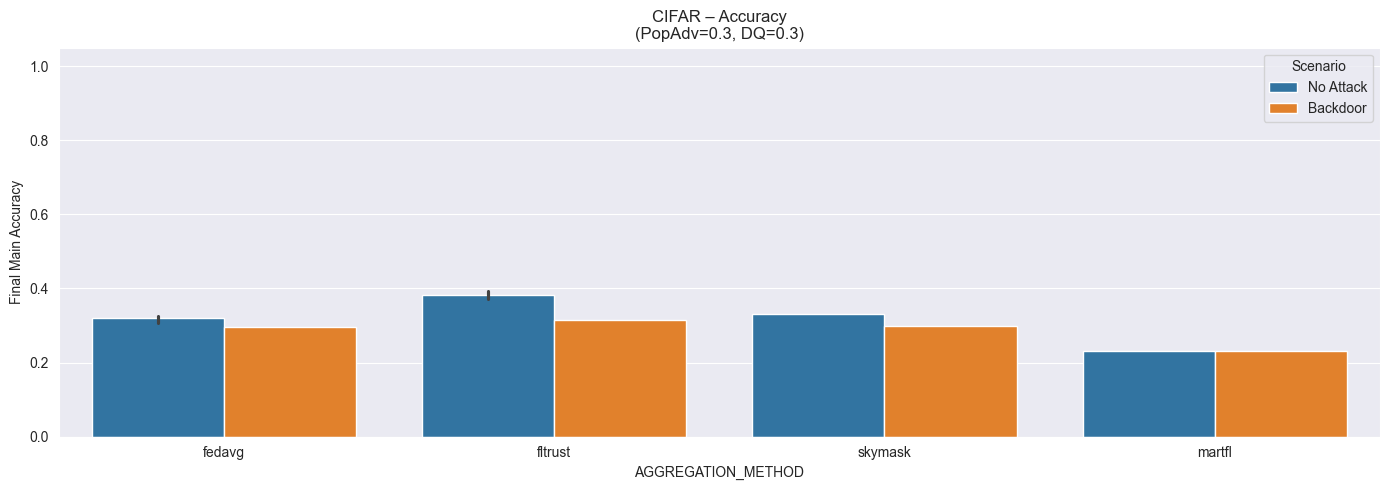

saved results\paper_figures\label_flipping_robustness_csv\acc_CIFAR_Backdoor.pdf


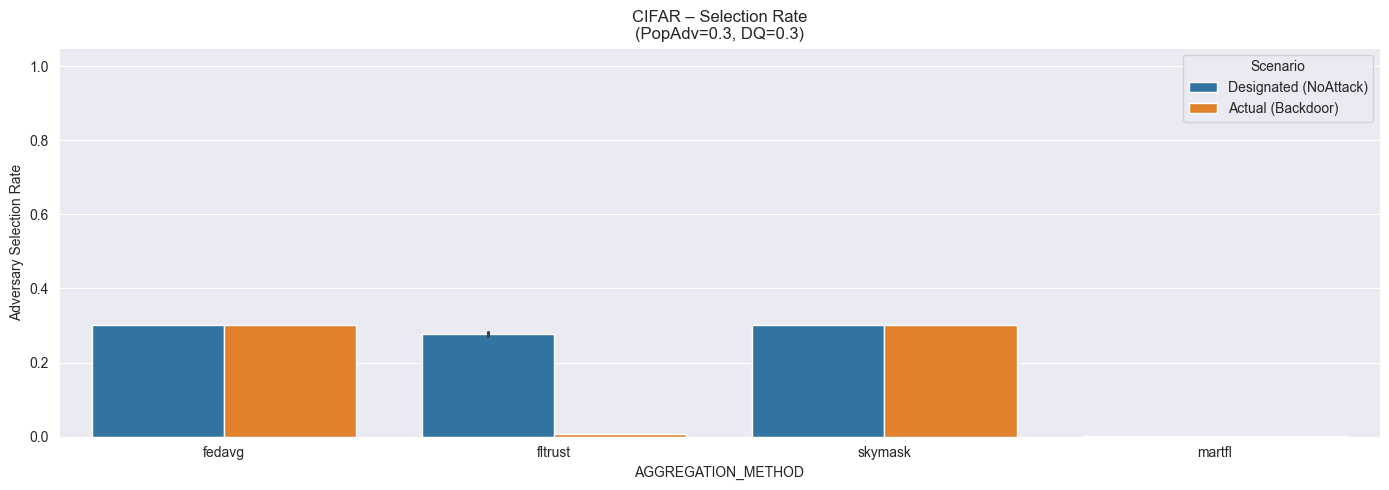

saved results\paper_figures\label_flipping_robustness_csv\sel_CIFAR_Backdoor.pdf
   AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
39            skymask         0.89000                      0.300000
41             martfl         0.84335                      0.004589
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
1              fedavg        0.900350                          0.300000
13            skymask        0.899400                          0.300000
14             fedavg        0.899467                          0.300000
16            fltrust        0.795733                          0.300000
18             martfl        0.850333                          0.332782
20             martfl        0.850333                          0.332782
21            skymask        0.899400                          0.300000
23             fedavg        0.899467                          0.300000
24            fltrust        0.795867                          0.30

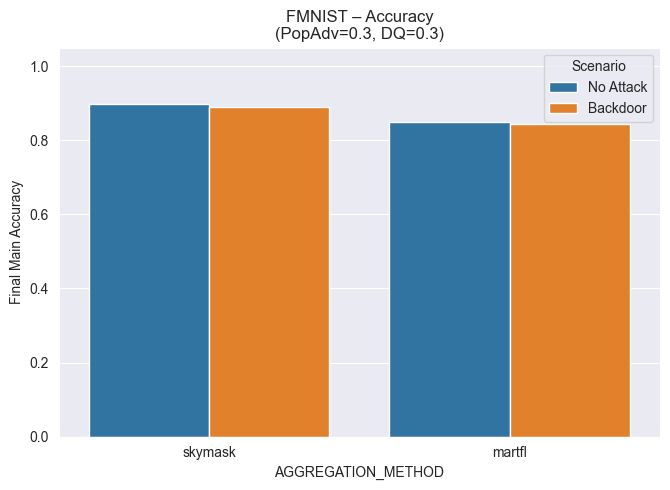

saved results\paper_figures\label_flipping_robustness_csv\acc_FMNIST_Backdoor.pdf


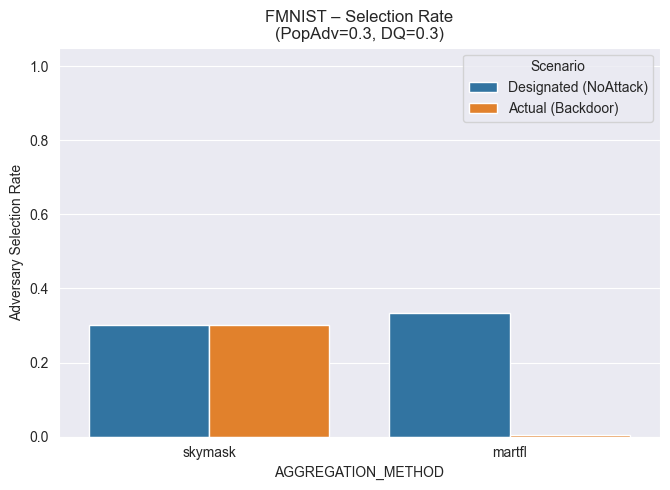

saved results\paper_figures\label_flipping_robustness_csv\sel_FMNIST_Backdoor.pdf
[skip] AG_NEWS: missing rows for attack=Backdoor


In [12]:

for ds in df["DATASET"].unique():
    for atk in ["Backdoor"]:     # add "Backdoor" if needed
        make_barplots(df, ds, atk)